In [1]:
import pandas as pd
song_df = pd.read_pickle("song_df_with_vectors.pkl")

In [2]:
song_df_cleaned = song_df.drop(['Unnamed: 0','text', 'label', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms','error'], axis=1)
song_df_cleaned.head(1)

,artist,song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,lyrics_vector
0,Elijah Blake,Everyday,0.783,0.563,6.0,-8.613,1.0,0.233,0.37,0.0,...,0.0005,0.385384,0.095446,0.0005,0.0005,0.0005,0.0005,0.515669,0.0005,"[0.01842727, 0.011369616, -0.05919706, 0.15994..."


In [3]:
song_df_cleaned = song_df_cleaned.dropna()

In [4]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

scaler = MinMaxScaler()

song_df_cleaned[['loudness', 'tempo']] = scaler.fit_transform(song_df_cleaned[['loudness', 'tempo']])

encoder = OneHotEncoder(sparse=False)

key_encoded = encoder.fit_transform(song_df_cleaned[['key']])
key_feature_names = encoder.get_feature_names_out(['key'])
df_key_encoded = pd.DataFrame(key_encoded, columns=key_feature_names, index=song_df_cleaned.index)

time_signature_encoded = encoder.fit_transform(song_df_cleaned[['time_signature']])
time_signature_feature_names = encoder.get_feature_names_out(['time_signature'])
df_time_signature_encoded = pd.DataFrame(time_signature_encoded, columns=time_signature_feature_names, index=song_df_cleaned.index)

song_df_preprocessed = pd.concat([song_df_cleaned.drop(['key', 'time_signature'], axis=1), 
                             df_key_encoded, df_time_signature_encoded], axis=1)

song_df_preprocessed.head()

C:\Users\maxhi\OneDrive\Documents\BDA-696-Python\bda_696_env\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\maxhi\OneDrive\Documents\BDA-696-Python\bda_696_env\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,artist,song,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,key_7.0,key_8.0,key_9.0,key_10.0,key_11.0,time_signature_0.0,time_signature_1.0,time_signature_3.0,time_signature_4.0,time_signature_5.0
0,Elijah Blake,Everyday,0.783,0.563,0.764058,1.0,0.2330,0.370000,0.000000,0.1090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Elijah Blake,Shadows & Diamonds,0.293,0.604,0.761595,1.0,0.0426,0.000607,0.000015,0.0877,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Elis,My Only Love,0.538,0.715,0.831325,0.0,0.0369,0.005820,0.000000,0.0976,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Elis,Rebirth,0.199,0.198,0.678327,0.0,0.0370,0.959000,0.939000,0.1130,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,Elis,Innocent Hearts,0.483,0.425,0.777443,0.0,0.0290,0.848000,0.000002,0.1200,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
song_df_preprocessed.columns

Index(['artist', 'song', 'danceability', 'energy', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'cleaned_text', 'topic_0', 'topic_1', 'topic_2',
       'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8',
       'topic_9', 'lyrics_vector', 'key_0.0', 'key_1.0', 'key_2.0', 'key_3.0',
       'key_4.0', 'key_5.0', 'key_6.0', 'key_7.0', 'key_8.0', 'key_9.0',
       'key_10.0', 'key_11.0', 'time_signature_0.0', 'time_signature_1.0',
       'time_signature_3.0', 'time_signature_4.0', 'time_signature_5.0'],
      dtype='object')

### Try encoding audio features with a lyric vector as target

In [10]:
feature_columns = [col for col in song_df_preprocessed.columns if col not in ('artist', 'song','cleaned_text', 'topic_0', 'topic_1', 'topic_2',
       'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8',
       'topic_9', 'lyrics_vector')]
X = song_df_preprocessed[feature_columns]

In [14]:
Y = np.stack(song_df_preprocessed['lyrics_vector'].values)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
def cosine_loss(y_true, y_pred):
    y_true = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred = tf.nn.l2_normalize(y_pred, axis=-1)
    return 1 - tf.reduce_mean(tf.reduce_sum(y_true * y_pred, axis=-1))


def build_lyric_predictor_model(input_dim, output_dim):
    input_layer = Input(shape=(input_dim,))

    x = Dense(256, activation='relu')(input_layer)  
    x = Dropout(0.2)(x)  
    x = Dense(128, activation='relu')(x)

    output_layer = Dense(output_dim, activation='linear')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(), loss=cosine_loss, metrics=['mean_absolute_error'])
    
    return model

input_dim = X.shape[1]
output_dim = Y.shape[1]  

model = build_lyric_predictor_model(input_dim, output_dim)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 27)]              0         
                                                                 
 dense_6 (Dense)             (None, 256)               7168      
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 300)               38700     
                                                                 
Total params: 78764 (307.67 KB)
Trainable params: 78764 (307.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
%%time
history = model.fit(X, Y, epochs=25, batch_size=32, validation_split=0.2)

Epoch 1/25
746/746 [==============================] - 2s 2ms/step - loss: 0.1421 - mean_absolute_error: 0.8532 - val_loss: 0.1292 - val_mean_absolute_error: 1.1157
Epoch 2/25
746/746 [==============================] - 1s 2ms/step - loss: 0.1312 - mean_absolute_error: 1.1695 - val_loss: 0.1284 - val_mean_absolute_error: 1.2451
Epoch 3/25
746/746 [==============================] - 1s 2ms/step - loss: 0.1304 - mean_absolute_error: 1.2196 - val_loss: 0.1279 - val_mean_absolute_error: 1.1493
Epoch 4/25
746/746 [==============================] - 1s 2ms/step - loss: 0.1301 - mean_absolute_error: 1.2269 - val_loss: 0.1279 - val_mean_absolute_error: 1.3894
Epoch 5/25
746/746 [==============================] - 1s 2ms/step - loss: 0.1299 - mean_absolute_error: 1.2898 - val_loss: 0.1278 - val_mean_absolute_error: 1.3762
Epoch 6/25
746/746 [==============================] - 1s 2ms/step - loss: 0.1297 - mean_absolute_error: 1.3651 - val_loss: 0.1279 - val_mean_absolute_error: 1.5162
Epoch 7/25
746/7

## Try encoding lyric vector first

In [24]:
def cosine_similarity_loss(y_true, y_pred):
    y_true_normalized = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred_normalized = tf.nn.l2_normalize(y_pred, axis=-1)
    return 1 - tf.reduce_mean(tf.reduce_sum(y_true_normalized * y_pred_normalized, axis=-1))

In [25]:
def create_autoencoder(dim_input, encoding_dim):
    input_lyric = Input(shape=(dim_input,))

    encoded = Dense(encoding_dim, activation='relu')(input_lyric)

    decoded = Dense(dim_input, activation='linear')(encoded)
    
    autoencoder = Model(input_lyric, decoded)
    
    encoder = Model(input_lyric, encoded)
    
    autoencoder.compile(optimizer='adam', loss=cosine_loss)
    return autoencoder, encoder

dim_input = Y.shape[1]  
encoding_dim = 64  

autoencoder, encoder = create_autoencoder(dim_input, encoding_dim)

In [26]:
autoencoder.fit(Y, Y,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_split=0.2)

Epoch 1/50
94/94 [==============================] - 1s 3ms/step - loss: 0.2115 - val_loss: 0.1061
Epoch 2/50
94/94 [==============================] - 0s 2ms/step - loss: 0.0973 - val_loss: 0.0881
Epoch 3/50
94/94 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0788
Epoch 4/50
94/94 [==============================] - 0s 2ms/step - loss: 0.0764 - val_loss: 0.0711
Epoch 5/50
94/94 [==============================] - 0s 2ms/step - loss: 0.0690 - val_loss: 0.0651
Epoch 6/50
94/94 [==============================] - 0s 2ms/step - loss: 0.0642 - val_loss: 0.0614
Epoch 7/50
94/94 [==============================] - 0s 2ms/step - loss: 0.0610 - val_loss: 0.0587
Epoch 8/50
94/94 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0566
Epoch 9/50
94/94 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0549
Epoch 10/50
94/94 [==============================] - 0s 2ms/step - loss: 0.0548 - val_loss: 0.0532
Epoch 11/50
94/94 [

In [27]:
encoded_lyrics = encoder.predict(Y)

933/933 [==============================] - 1s 614us/step


In [29]:
def build_predictive_model(input_dim, output_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(256, activation='relu')(input_layer)  
    x = Dropout(0.2)(x)  
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(output_dim, activation='linear')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss=cosine_loss)
    return model

predictive_model = build_predictive_model(X.shape[1], encoding_dim)

predictive_model.fit(X, encoded_lyrics,
                     epochs=50,
                     batch_size=32,
                     validation_split=0.2)

Epoch 1/50
746/746 [==============================] - 1s 1ms/step - loss: 0.0617 - val_loss: 0.0509
Epoch 2/50
746/746 [==============================] - 1s 1ms/step - loss: 0.0519 - val_loss: 0.0504
Epoch 3/50
746/746 [==============================] - 1s 1ms/step - loss: 0.0516 - val_loss: 0.0502
Epoch 4/50
746/746 [==============================] - 1s 1ms/step - loss: 0.0514 - val_loss: 0.0501
Epoch 5/50
746/746 [==============================] - 1s 1ms/step - loss: 0.0512 - val_loss: 0.0501
Epoch 6/50
746/746 [==============================] - 1s 1ms/step - loss: 0.0512 - val_loss: 0.0500
Epoch 7/50
746/746 [==============================] - 1s 1ms/step - loss: 0.0511 - val_loss: 0.0499
Epoch 8/50
746/746 [==============================] - 1s 1ms/step - loss: 0.0510 - val_loss: 0.0500
Epoch 9/50
746/746 [==============================] - 1s 1ms/step - loss: 0.0510 - val_loss: 0.0499
Epoch 10/50
746/746 [==============================] - 1s 1ms/step - loss: 0.0510 - val_loss: 0.0499

### Try extracting latent features with a multitask autoencoder

In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

def build_multitask_autoencoder(input_dim, encoded_lyrics_dim, latent_dim):
    input_layer = Input(shape=(input_dim,), name='input_layer')

    encoder_output = Dense(latent_dim, activation='relu', name='encoder_output')(input_layer)

    decoder_output = Dense(input_dim, activation='sigmoid', name='decoder_output')(encoder_output)

    lyric_pred_output = Dense(encoded_lyrics_dim, activation='linear', name='lyric_pred_output')(encoder_output)

    autoencoder = Model(inputs=input_layer, outputs=[decoder_output, lyric_pred_output])

    autoencoder.compile(optimizer='adam', 
                        loss={'decoder_output': 'mse', 'lyric_pred_output': cosine_similarity_loss}, 
                        loss_weights={'decoder_output': 1.0, 'lyric_pred_output': 0.5})

    return autoencoder

input_dim = X.shape[1]  
encoded_lyrics_dim = encoded_lyrics.shape[1]  
latent_dim = 64  


multitask_autoencoder = build_multitask_autoencoder(input_dim, encoded_lyrics_dim, latent_dim)
multitask_autoencoder.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 27)]                 0         []                            
                                                                                                  
 encoder_output (Dense)      (None, 64)                   1792      ['input_layer[0][0]']         
                                                                                                  
 decoder_output (Dense)      (None, 27)                   1755      ['encoder_output[0][0]']      
                                                                                                  
 lyric_pred_output (Dense)   (None, 64)                   4160      ['encoder_output[0][0]']      
                                                                                           

In [36]:
history = multitask_autoencoder.fit(
    X, 
    {'decoder_output': X, 'lyric_pred_output': encoded_lyrics}, 
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/50
746/746 [==============================] - 1s 1ms/step - loss: 0.0849 - decoder_output_loss: 0.0452 - lyric_pred_output_loss: 0.0793 - val_loss: 0.0352 - val_decoder_output_loss: 0.0092 - val_lyric_pred_output_loss: 0.0520
Epoch 2/50
746/746 [==============================] - 1s 983us/step - loss: 0.0303 - decoder_output_loss: 0.0041 - lyric_pred_output_loss: 0.0524 - val_loss: 0.0273 - val_decoder_output_loss: 0.0018 - val_lyric_pred_output_loss: 0.0509
Epoch 3/50
746/746 [==============================] - 1s 968us/step - loss: 0.0271 - decoder_output_loss: 0.0012 - lyric_pred_output_loss: 0.0518 - val_loss: 0.0261 - val_decoder_output_loss: 7.7935e-04 - val_lyric_pred_output_loss: 0.0506
Epoch 4/50
746/746 [==============================] - 1s 966us/step - loss: 0.0263 - decoder_output_loss: 5.4979e-04 - lyric_pred_output_loss: 0.0516 - val_loss: 0.0257 - val_decoder_output_loss: 4.2814e-04 - val_lyric_pred_output_loss: 0.0504
Epoch 5/50
746/746 [==========================

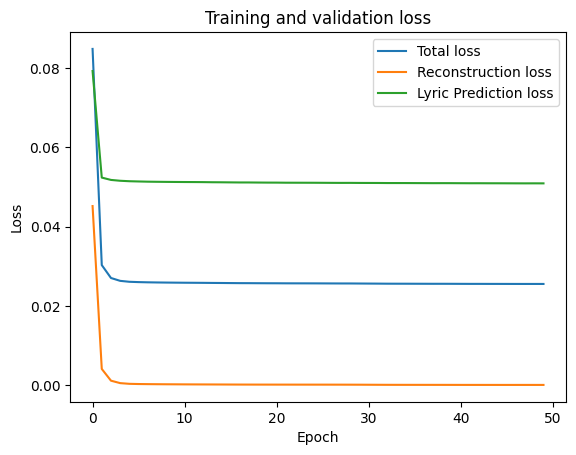

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Total loss')
plt.plot(history.history['decoder_output_loss'], label='Reconstruction loss')
plt.plot(history.history['lyric_pred_output_loss'], label='Lyric Prediction loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
encoder_input = multitask_autoencoder.input
encoder_output = multitask_autoencoder.get_layer('encoder_output').output
encoder_model = Model(encoder_input, encoder_output)

In [39]:
latent_features = encoder_model.predict(X)

933/933 [==============================] - 1s 584us/step


In [52]:
type(latent_features)

numpy.ndarray

In [45]:
from sklearn.metrics.pairwise import cosine_similarity
def recommend_songs_by_title_and_artist(title, artist, df, top_n=5):
    song_index = df[(df['song'] == title) & (df['artist'] == artist)].index[0]
    
    song_feature = latent_features[song_index].reshape(1, -1)
    
    similarities = cosine_similarity(song_feature, latent_features).flatten()
    
    similar_indices = np.argsort(-similarities)[1:top_n+1]
    
    return df.loc[similar_indices, ['song', 'artist']]

recommendations = recommend_songs_by_title_and_artist('The Monster', 'Eminem', song_df_preprocessed, top_n=5)
print(recommendations)

                song                      artist
17698     Lesson One                   Just Jack
23858     Old School               Lyfe Jennings
11954  Barbara Allen  The New Lost City Ramblers
16916       One Life            The Last Emperor
10037   Bone Exposed         Malevolent Creation


In [46]:
import numpy as np
n_topics = 20
lda_features = song_df_preprocessed[[f'topic_{i}' for i in range(n_topics)]].values
word2vec_features = np.array(song_df_preprocessed['lyrics_vector'].tolist())


In [47]:
def combine_features(audio_features, word2vec_features, lda_features, audio_weight=1.0, word2vec_weight=1.0, lda_weight=1.0):
    scaler = StandardScaler()
    audio_norm = scaler.fit_transform(audio_features) * audio_weight
    word2vec_norm = scaler.fit_transform(word2vec_features) * word2vec_weight
    lda_norm = scaler.fit_transform(lda_features) * lda_weight
    combined_features = np.hstack((audio_norm, word2vec_norm, lda_norm))
    return combined_features

In [48]:
def recommend_songs_by_title_and_artist(title, artist, df, combined_features, top_n=5):

    song_index = df[(df['song'] == title) & (df['artist'] == artist)].index[0]

    song_feature = combined_features[song_index].reshape(1, -1)
    
    similarities = cosine_similarity(song_feature, combined_features).flatten()
  
    similar_indices = np.argsort(-similarities)[1:top_n+1]

    return df.loc[similar_indices, ['song', 'artist']]

In [61]:
from sklearn.preprocessing import StandardScaler
word2vec_features = np.array(song_df_preprocessed['lyrics_vector'].tolist())
lda_features = song_df_preprocessed[[f'topic_{i}' for i in range(10)]].values

combined_features = combine_features(
    latent_features,  
    word2vec_features,
    lda_features,
    audio_weight=0.5, 
    word2vec_weight=1, 
    lda_weight=0.5
)

song_title = 'Monster'
song_artist = 'Kanye West'
recommendations = recommend_songs_by_title_and_artist(song_title, song_artist, song_df_preprocessed, combined_features, top_n=5)
print(recommendations)

                            song                artist
4735                 San Jacinto         Peter Gabriel
25123            Cuban Love Song   Igniters Steel Band
25124  I Cant' Stay Here Anymore        IIIrd Tyme Out
22025              Little Maggie  The Stanley Brothers
17728            Thinking of You        Justin Guarini
